# Optical Image Growth Rate Calculator
This notebook is used to find areal and facet growth rates for single crystals from optical microscopy images. The data is assumed to be h5py files but the functions can be used once images (as 2D float32 arrays), timestamps, and a scale are fed in.

## Useful imports

In [1]:
import hyperspy.api as hs                 # hyperspectral data processing and some useful image viewing
import h5py                               # to handle .h5 files
from matplotlib import pyplot as plt      # Plotting
import numpy as np                        # Maths
import cv2                                # Image analysis
from os import walk                       # To get filepaths automatically
from natsort import natsorted             # To easily resort file order
from datetime import datetime             # For easily parsing timestamps
import warnings
warnings.filterwarnings("ignore")         # Attempt to remove some unnecessary pyplot warnings
from scipy.interpolate import interp1d
import optical_image_functions as oif

## Folder Selection

In [2]:
folder = r'C:\Users\es758\Documents\Python Scripts\Mini 1\Reflection data subset\\'

Can inspect the structure of the files by running the below code.

In [3]:
# fpaths = oif.get_filepaths(folder)
# fpath=fpaths[0]
# oif.get_h5py_contents(fpath)

## Image Data Extraction

In [4]:
# Some base code for the below is all in test_notebook
# Plot times by using a to be made plotting function?
# Plot specific image function?
# Plot hs time series function?
# backend maplotlib chooser like George?

Extracting images and timestamps using suggested function which truncates series if a large discontinuity in timestamp is detected.

In [5]:
ts, images, pixel_size = oif.get_data_h5py(folder)

## Image Pre-Processing

Currently imperfect. Will need to refine for single image before have final automated one added to oif.
Currently produces double border around crystal

In [6]:
def get_binary(im):
    return oif.threshold_image(oif.sobel_2D(oif.open_image(oif.blur_image(im))))

In [7]:
# plot contours could be adapted from test notebook too to incldue scale etc.

In [8]:
# not added to functions because depends on get_binary
def get_contour_data(images):
    contour_sets = []
    area_sets = []
    perim_sets = []
    for im in images:
        bim = get_binary(im)
        contours_filtered, areas_filtered, perims_filtered = oif.get_contours(bim)
        contour_sets.append(contours_filtered)
        area_sets.append(areas_filtered)
        perim_sets.append(perims_filtered)
    return contour_sets, area_sets, perim_sets

In [9]:
def extract_best_contour_data(contour_sets, area_sets, perim_sets):
    best_contours = []
    best_areas = []
    best_perims = []
    for i in np.arange(len(contour_sets)):
        criterion = np.max(area_sets[i])
        best_areas.append(criterion)
        j = area_sets[i].index(criterion)
        best_contours.append(contour_sets[i][j])
        best_perims.append(perim_sets[i][j])
    return best_contours, best_areas, best_perims

In [10]:
def extract_growth_rate(area_series, time_series):
    gro_series = []
    index_list = np.arange(len(area_series))
    for i in index_list:
        if i == 0:
            rate = (area_series[1] - area_series[0])/(time_series[1]-time_series[0])
        elif i == index_list[-1]:
            rate = (area_series[-1] - area_series[-2])/(time_series[-1]-time_series[-2])
        else:
            rate = (area_series[i+1] - area_series[i-1])/(time_series[i+1]-time_series[i-1])
        gro_series.append(rate)
    return gro_series
            
# def fix_area_data(area_series, time_series):
#     """
#     Interpolates area if contours fail for a time and slices data to just frames before the crystal reaches the edge of the field of view
#     Maybe add later a way of marking data where have done this?
#     Probably could do something smart with try and except here.
#     """
    
#     gro_series = extract_growth_rate(area_series, time_series)
    
#     cleaned_area_series = []
#     cleaned_time_series = []
    
#     # maybe should tell by rate instead? But need to distinguish between blips and edge so both I reckon
#     index_list = np.arange(len(area_series))
#     for i in index_list:
#         if i == 0 or i == index_list[-1]:
#             cleaned_area_series.append(area_series[i])
#         elif abs(gro_series[i]) > 10*abs(gro_series[i-1]):
#             # check if area value has collapsed due to reaching the edge of the field of view
#             # should probably have warnings that either the area has reached the edge or just got unlucky with which evaluations failed. WIll for now make reliant on not getting 2 bad
#             # in a row for sake of catching dodgy data
#             if area_series[i+1] < area_series[i-1]:
#                 # cut off
#                 cleaned_time_series = time_series[:len(cleaned_area_series)]
#                 break
#             else:
#                 #interpolate
#                 area_interp = [area_series[i-1], area_series[i+1]]
#                 time_interp = [time_series[i-1], time_series[i+1]]
#                 f = interp1d(time_interp, area_interp, kind='linear')
#                 cleaned_area_series.append(f(time_series[i]))
#         else:
#             cleaned_area_series.append(area_series[i])
                
    
#     return cleaned_area_series, cleaned_time_series
def fix_area_data(area_series, time_series):
    """
    Interpolates area if contours fail for a time and slices data to just frames before the crystal reaches the edge of the field of view
    Maybe add later a way of marking data where have done this?
    Probably could do something smart with try and except here.
    """
    cleaned_area_series = []
    cleaned_time_series = []
    
    # maybe should tell by rate instead? But need to distinguish between blips and edge so both I reckon
    index_list = np.arange(len(area_series))
    for i in index_list:
        if i == 0 or i == index_list[-1]:
            cleaned_area_series.append(area_series[i])
        elif i == 1:
            cleaned_area_series.append(area_series[i])
        elif abs(area_series[i]-cleaned_area_series[i-1]) > 100*abs(cleaned_area_series[i-1]-cleaned_area_series[i-2]):
    
            if area_series[i+1] < cleaned_area_series[i-1]:
                # cut off
                # could try make so allows thing to shrink
                cleaned_time_series = time_series[:len(cleaned_area_series)]
                break
            else:
                #interpolate
                area_interp = [cleaned_area_series[i-1], area_series[i+1]]
                time_interp = [time_series[i-1], time_series[i+1]]
                f = interp1d(time_interp, area_interp, kind='linear')
                cleaned_area_series.append(f(time_series[i]))
        else:
            cleaned_area_series.append(area_series[i])
                
    # am I misssing an apend time series somewhere?
    # At present ok because take whole time series once touches edge but should 
    # I suppose an alternative to what I have done would be to just skip out area and time rather than interpolating. Especially if messes up later in facets.
    return cleaned_area_series, cleaned_time_series

# cut off happens if more than 2 blips in a row as well as for normal cut off
# blip detection works ok but if only one normal value inbetween 2 blips I don't think it will recognise the second one. 
# therefore maybe I should change so makes new area list to reference past values as it goes rather than what doing now. Future i ones can still be the original.
#this simple change to above so will do

# weakness still can't handle if area contours mess up more than a few tiems and can't tell if because if hit edge or is this. Most likely edge though.



# probably change to skipping out, can't gain much from interpolation. Not adding information. Tell it to put Nan? But handle for growth rate. Is then a flag for where data missing.

# try remove the double threshold. Hard to play with to make general but could try put some things in place.
# 


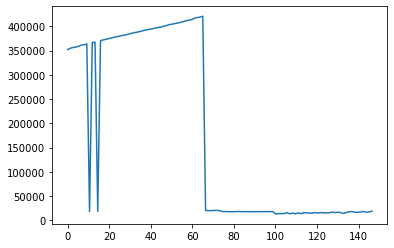

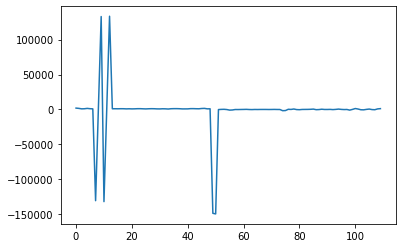

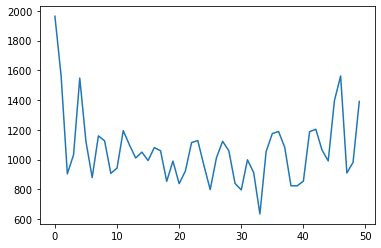

In [11]:
contour_sets, area_sets, perim_sets = get_contour_data(images)
best_contours, best_areas, best_perims = extract_best_contour_data(contour_sets, area_sets, perim_sets)
plt.plot( ts, best_areas)
plt.show()
plt.plot(extract_growth_rate(best_areas, ts))
plt.show()
cleaned_area_series, cleaned_time_series = fix_area_data(best_areas, ts)
plt.plot(extract_growth_rate(cleaned_area_series, cleaned_time_series))
plt.show()

In [12]:
def rotate_image(im, angle):
    row, col = im.shape
    image_centre = tuple(np.array([row, col])/2)
    rot_mat = cv2.getRotationMatrix2D(image_centre, angle, 1.0)
    result = cv2.warpAffine(im, rot_mat, (col, row), flags=cv2.INTER_LINEAR) # warpAffine takes shape in reverse order
    return result

def onedimify(im):
    #row, col = im.shape
    im_1D_av = []
    for row in im:
        im_1D_av.append(np.average(row))
    return im_1D_av

def find_alignment(im, step_degree=1):
    angles = np.arange(0, 90+step_degree, step_degree) # if only allow 90 degrees won't necessarily find the alignement with the 
    # longest face because it doesn't rotate back, I've tried. Need to let it do 180 degrees.
    # better to do this than not know which it is finding? Or maybe if end up extracting growth rate both directions then doesn't matter
    biggest_signals = []
    for angle in angles:
        rotated_image = rotate_image(im, angle)
        onedim = onedimify(rotated_image)
        biggest_signals.append(np.max(onedim))
    best_alignment = angles[biggest_signals.index(np.max(biggest_signals))]
    return best_alignment

54


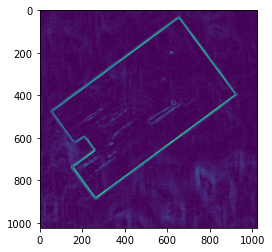

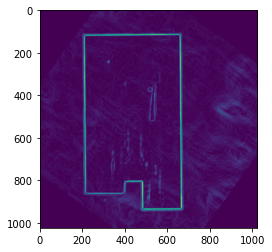

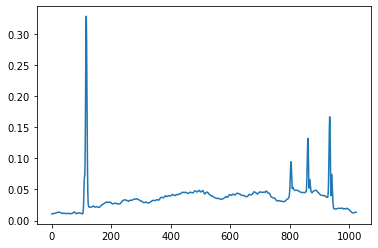

In [16]:
image_test=images[0].copy()
sobel = oif.sobel_2D(oif.open_image(oif.blur_image(image_test)))
print(find_alignment(sobel, 1))
plt.imshow(sobel)
plt.show()
plt.imshow(rotate_image(sobel, 54))
plt.show()
plt.plot(onedimify(rotate_image(sobel, 54)))

In [63]:
rotated_images = []
onedimified_images=[]
for im in images:
    sobel=oif.sobel_2D(oif.open_image(oif.blur_image(im)))
    rot_sobel = rotate_image(sobel, 54)
    onedimified_images.append(onedimify(rot_sobel))
    rotated_images.append(rot_sobel)
print("done")
# note for future that sobel has to be applied before rotation or corners turn up weird.

done


In [64]:
%matplotlib qt
s = hs.signals.Signal2D(rotated_images)
s.plot()

In [65]:
onedim = hs.signals.Signal1D(onedimified_images)
onedim.plot()

  0%|          | 0/1 [00:00<?, ?it/s]

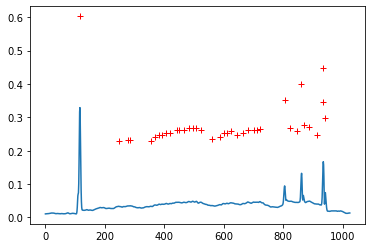

In [87]:
%matplotlib inline
a= onedimified_images[0]
s = hs.signals.Signal1D(a)
peaks = s.find_peaks1D_ohaver()

plt.plot(a)
position = [i[0] for i in peaks[0]]
height = [i[1] for i in peaks[0]]
plt.plot(position, height, 'r+')
plt.show()

find_peaks1D_ohaver(xdim=None, slope_thresh=0, amp_thresh=None, subchannel=True, medfilt_radius=5, maxpeakn=30000, peakgroup=10, parallel=None, max_workers=None)

‘slope_thresh’ and ‘amp_thresh’, control sensitivity: higher values will neglect broad peaks (slope) and smaller features (amp), respectively.

peakgroup is the number of points around the top of the peak that are taken to estimate the peak height. For spikes or very narrow peaks, set peakgroup to 1 or 2; for broad or noisy peaks, make peakgroup larger to reduce the effect of noise.

  0%|          | 0/1 [00:00<?, ?it/s]

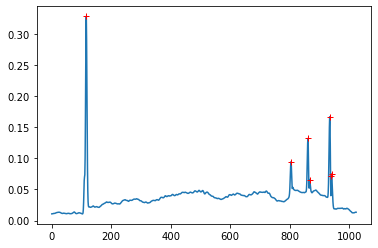

In [115]:
%matplotlib inline
a= onedimified_images[0]
s = hs.signals.Signal1D(a)
#peaks = s.find_peaks1D_ohaver(peakgroup=2)
#peaks = s.find_peaks1D_ohaver(slope_thresh=0.001)
#peaks = s.find_peaks1D_ohaver(amp_thresh=0.05)
peaks = s.find_peaks1D_ohaver(peakgroup=2,slope_thresh=0.001)
plt.plot(a)
position = [i[0] for i in peaks[0]]
height = [i[1] for i in peaks[0]]
plt.plot(position, height, 'r+')
plt.show()